In [1]:
from collections import defaultdict
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import torch.nn as nn
from torch.optim import AdamW
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import pickle

In [2]:
import random

def set_random_seed(seed_value):
    """Set the random seed for reproducibility."""
    random.seed(seed_value)  # Set the seed for Python's random module
    np.random.seed(seed_value)  # Set the seed for NumPy
    torch.manual_seed(seed_value)  # Set the seed for PyTorch CPU
    torch.cuda.manual_seed(seed_value)  # Set the seed for PyTorch
    torch.cuda.manual_seed_all(seed_value)  # Set the seed for all GPUs
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior on GPU
    torch.backends.cudnn.benchmark = False  # Turn off benchmarks for reproducibility

set_random_seed(42)

In [3]:
# Load the data
def load_data():
    reviews = pd.read_pickle('../Pickle/reviews.pkl')
    books_list = []
    with open('../Pickle/books.pkl', 'rb') as file:
        while True:
            try:
                books_list.append(pickle.load(file))
            except EOFError:
                break
    books = pd.concat(books_list, ignore_index=True).drop_duplicates(subset='title', keep='first')

    read = pd.read_pickle('../Pickle/read.pkl')
    user_genres = pd.read_pickle('../Pickle/user_most_common_genres.pkl')
    review_embeddings = pd.read_pickle('../Pickle/review_embeddings.pkl')
    review_sentiment = pd.read_pickle('../Pickle/review_score.pkl')
    imputed = pd.read_pickle('../Pickle/imputed_ratings.pkl')
    return reviews, books, read, user_genres, review_embeddings, review_sentiment, imputed

In [4]:
def split_data(ratings_data, user_genres, test_size=0.1, val_size=0.15, random_state=42):

    """
    Splits the ratings data into training, validation, and test datasets while handling users and books
    that have limited interactions. It first removes interactions involving users or books that appear 
    only once in the dataset and then performs the data split.

    Args:
    ratings_data (DataFrame): A dataframe containing the ratings data with columns 'user_id' and 'book_id'.
    user_genres (DataFrame): A dataframe containing 'user_id' and the most common genres for each user.
    test_size (float, optional): The proportion of data to be used as the test set. Default is 0.1 (10%).
    val_size (float, optional): The proportion of data to be used as the validation set. Default is 0.15 (15%).
    random_state (int, optional): The seed for the random number generator to ensure reproducibility. Default is 42.

    Returns:
    tuple: A tuple containing three DataFrames:
        - train_data (DataFrame): The training dataset, including interactions where users or books appear only once.
        - val_data (DataFrame): The validation dataset.
        - test_data (DataFrame): The test dataset.

    Notes:
    - The function removes interactions where a user or book appears only once in the dataset to prevent data sparsity issues.
    - The remaining interactions are split into train, validation, and test sets, with the validation and test sizes being proportionally adjusted.
    - The single interactions (those involving users or books that appear only once) are added back to the training set.
    """
    merged_data = ratings_data.merge(user_genres[['user_id', 'most_common_genres']], on='user_id', how='inner')
    user_counts = merged_data['user_id'].value_counts()
    book_counts = merged_data['book_id'].value_counts()
    single_interactions = merged_data[
        merged_data['user_id'].isin(user_counts[user_counts == 1].index) | 
        merged_data['book_id'].isin(book_counts[book_counts == 1].index)
    ]

    remaining_interactions = merged_data[~merged_data.index.isin(single_interactions.index)]
    train_df, temp_data = train_test_split(remaining_interactions, test_size=test_size+val_size, random_state=random_state)
    val_data, test_data = train_test_split(temp_data, test_size=test_size/(test_size+val_size), random_state=random_state)

    train_data = pd.concat([train_df, single_interactions], ignore_index=True)

    return train_data, val_data, test_data

In [5]:
def initialize_id_mappings(combined_data):
    """
    Initializes mappings between user IDs and book IDs to integer indices.

    Args:
    combined_data (DataFrame): A dataframe containing user-item interactions, with columns 'user_id' and 'book_id'.

    Returns:
    tuple: A tuple containing two dictionaries:
        - user_id_to_index (dict): A mapping of unique user IDs to integer indices.
        - book_id_to_index (dict): A mapping of unique book IDs to integer indices.

   """
    unique_user_ids = set(combined_data['user_id'])
    unique_book_ids = set(combined_data['book_id'])
    user_id_to_index = {user_id: idx for idx, user_id in enumerate(unique_user_ids)}
    book_id_to_index = {book_id: idx for idx, book_id in enumerate(unique_book_ids)}
    return user_id_to_index, book_id_to_index

In [6]:
def balance_ratings(
    train_df,
    rating_col='rating',
    balance_ratio=0.75,
    noise_range=(-0.1, 0.1),
    rating_min=1,
    rating_max=5,
    random_state=42
):
    """
    Balance the rating distribution by upsampling and adding small noise.

    Args:
        train_df (pd.DataFrame): Training dataframe containing a rating column.
        rating_col (str): The name of the rating column in the dataframe.
        balance_ratio (float): Target ratio relative to the majority class count.
        noise_range (tuple): Range (min, max) of uniform noise to add to ratings during upsampling.
        rating_min (float): Minimum allowable rating after adding noise.
        rating_max (float): Maximum allowable rating after adding noise.
        random_state (int): Random seed for reproducibility.

    Returns:
        pd.DataFrame: A balanced and shuffled dataframe.
    """
    rating_counts = train_df[rating_col].value_counts()
    majority_count = rating_counts.max()
    max_target_size = int(balance_ratio * majority_count)

    modified_dfs = []
    for rating, count in rating_counts.items():
        class_df = train_df[train_df[rating_col] == rating]

        if count >= max_target_size:
            balanced_df = class_df.copy()
        else:
            balanced_df = resample(
                class_df,
                replace=True,
                n_samples=max_target_size,
                random_state=random_state
            )

            noise = np.random.uniform(noise_range[0], noise_range[1], size=balanced_df.shape[0])
            balanced_df[rating_col] = balanced_df[rating_col] + noise

            balanced_df[rating_col] = balanced_df[rating_col].clip(rating_min, rating_max)

        modified_dfs.append(balanced_df)

    balanced_train = pd.concat(modified_dfs, ignore_index=True)

    balanced_train = balanced_train.sample(frac=1, random_state=random_state).reset_index(drop=True)

    return balanced_train

In [7]:
def normalise_ratings(train_data, test_data, val_data):
    """
    Normalizes the ratings in the train, test, and validation datasets using a log scale transformation.

    This function applies a log1p transformation (log(x + 1)) to the ratings to reduce the skewness of the rating distribution.

    Args:
    train_data (DataFrame): Training dataset containing ratings.
    test_data (DataFrame): Testing dataset containing ratings.
    val_data (DataFrame): Validation dataset containing ratings.

    Returns:
    tuple: A tuple containing:
        - The normalized training dataset (with log-scaled ratings).
        - The normalized testing dataset (with log-scaled ratings).
        - The normalized validation dataset (with log-scaled ratings).
        - The minimum rating value in the training dataset (before normalization).
    """
    min_rating = train_data['rating'].min()
    train_data['rating'] = np.log1p(train_data['rating'])
    test_data['rating'] = np.log1p(test_data['rating'])
    val_data['rating'] = np.log1p(val_data['rating'])
    
    return train_data, test_data, val_data, min_rating


def denormalize_rating(log_scaled_ratings, min_rating):
    """
    Denormalizes the log-scaled ratings back to their original scale.

    This function reverses the log1p transformation applied during normalization and adjusts for the minimum rating.
    The resulting ratings are clipped to a range between 0 and 5.

    Args:
    log_scaled_ratings (list or array-like): Log-transformed ratings (using log1p).
    min_rating (float): The minimum rating value before normalization.

    Returns:
    np.ndarray: The denormalized ratings, clipped between 0 and 5.

    """
    log_scaled_ratings = np.asarray(log_scaled_ratings, dtype=float)  # Ensure NumPy array
    # Reverse log1p transformation
    original_ratings = np.expm1(log_scaled_ratings)
    # Adjust for minimum rating
    if min_rating:
        original_ratings += min_rating
    # Clip values between 0 and 5
    return np.clip(original_ratings, 0, 5)


In [8]:
def user_book_features(filtered_data, user_id_to_index, book_id_to_index):
    """
    Generates user and book genre features based on the most common genres for users and the filtered genres for books.

    This function creates feature vectors representing the genres for both users and books. For users, it combines their 
    most common genres into a feature vector. For books, it combines the filtered genres into a feature vector. These vectors 
    are represented as binary vectors where each genre corresponds to a dimension, and a 1 indicates the presence of the genre.

    Args:
    filtered_data (DataFrame): DataFrame containing user-book interactions, including columns 'user_id', 'book_id', 
                                'filtered_genres', and 'most_common_genres'.
    user_id_to_index (dict): A dictionary mapping user IDs to internal indices.
    book_id_to_index (dict): A dictionary mapping book IDs to internal indices.

    Returns:
    tuple: A tuple containing:
        - user_genre_features (dict): A dictionary where the keys are user indices and the values are torch tensors
                                      representing the binary genre vectors for each user.
        - book_genre_features (dict): A dictionary where the keys are book indices and the values are torch tensors
                                      representing the binary genre vectors for each book.

    """
    # Combine user and book genres to create a unified genre list
    unique_genres = sorted(set(filtered_data['filtered_genres'].str.split(',').explode()).union(
        set(filtered_data['most_common_genres'].explode())
    ))

    # Create a common genre dictionary
    genre_dict = {genre: idx for idx, genre in enumerate(unique_genres)}
    
    # Prepare user genre features
    user_genre_features = {}
    # Group by user_id and process all genres at once
    for user_id, group in filtered_data.groupby('user_id'):
        genres = group['most_common_genres'].iloc[0]  # All rows for this user should have the same genres
        genre_vector = np.zeros(len(genre_dict))  # Size based on the unified genre list
        for genre in genres:
            if genre in genre_dict:
                genre_vector[genre_dict[genre]] = 1
        user_genre_features[user_id_to_index[user_id]] = torch.tensor(genre_vector, dtype=torch.float32)

    # Prepare book genre features
    book_genre_features = {}
    for book_id, group in filtered_data.groupby('book_id'):
        genres = group['filtered_genres'].iloc[0].split(',')  # Assuming all rows for this book have the same genres
        genre_vector = np.zeros(len(genre_dict))  # Size based on the unified genre list
        for genre in genres:
            if genre in genre_dict:
                genre_vector[genre_dict[genre]] = 1
        book_genre_features[book_id_to_index[book_id]] = torch.tensor(genre_vector, dtype=torch.float32)

    return user_genre_features, book_genre_features


In [9]:
def prepare_edge_index_ratings_attributes(df, user_id_to_index, book_id_to_index):
    """
    Prepares the edge index and associated attributes for a graph-based recommendation system, where the nodes represent 
    users and books, and the edges represent interactions between them with ratings, confidence scores, and embeddings.

    This function processes the user-book interactions, maps user and book IDs to their respective indices, and generates
    the edge index as well as the edge attributes, which include ratings, confidence scores, and embeddings.

    Args:
    df (DataFrame): DataFrame containing the user-book interactions with columns 'user_id', 'book_id', 'rating', 
                    'confidence_score', and 'embeddings'.
    user_id_to_index (dict): A dictionary mapping user IDs to internal user indices.
    book_id_to_index (dict): A dictionary mapping book IDs to internal book indices.

    Returns:
    tuple: A tuple containing:
        - edge_index (torch.Tensor): A tensor of shape (2, num_edges) representing the user-book pairs as edges in the graph.
        - edge_attr (torch.Tensor): A tensor of shape (num_edges, 3 + embedding_size) representing the edge attributes,
                                   concatenating ratings, confidence scores, and embeddings.

    """
    # Map user and book IDs to indices
    user_indices = df['user_id'].map(user_id_to_index).dropna().astype(int).values
    book_indices = df['book_id'].map(book_id_to_index).dropna().astype(int).values

    # Ensure valid mappings
    valid_mask = (user_indices >= 0) & (book_indices >= 0)
    user_indices = user_indices[valid_mask]
    book_indices = book_indices[valid_mask]

    # Create edge index
    edge_index = torch.tensor([user_indices, book_indices], dtype=torch.long)

    # Convert ratings and confidence scores to tensors
    ratings_tensor = torch.tensor(df.loc[valid_mask, 'rating'].values, dtype=torch.float32).view(-1, 1)
    confidence_tensor = torch.tensor(df.loc[valid_mask, 'confidence_score'].values, dtype=torch.float32).view(-1, 1)

    # Efficiently convert list of NumPy arrays to a tensor
    embeddings_np = np.stack(df.loc[valid_mask, 'embeddings'].values)  # Stack directly
    embeddings_tensor = torch.from_numpy(embeddings_np).float()  # Convert efficiently

    # Concatenate ratings, confidence scores, and embeddings into a single edge attribute tensor
    edge_attr = torch.cat([ratings_tensor, confidence_tensor, embeddings_tensor], dim=1)

    return edge_index, edge_attr


In [10]:
def prepare_data_objects(train_data, val_data, test_data, user_genre_features, book_genre_features, user_id_to_index, book_id_to_index):
    """
    Prepares the data objects for a graph-based recommendation system, including the edge indices, edge attributes, 
    and node features for users and books. These objects are used for training, validation, and testing in PyTorch Geometric (PyG).

    The function processes the input data, creates embeddings for users and books based on their genres, and constructs 
    the corresponding graph structures with the appropriate edge indices and attributes. The resulting PyG data objects 
    can then be used for graph-based learning.

    Args:
    train_data (DataFrame): The training set containing user-book interactions with ratings, confidence scores, and embeddings.
    val_data (DataFrame): The validation set containing user-book interactions with ratings, confidence scores, and embeddings.
    test_data (DataFrame): The test set containing user-book interactions with ratings, confidence scores, and embeddings.
    user_genre_features (dict): A dictionary where keys are user indices and values are tensors representing user genre features.
    book_genre_features (dict): A dictionary where keys are book indices and values are tensors representing book genre features.
    user_id_to_index (dict): A dictionary mapping user IDs to internal user indices.
    book_id_to_index (dict): A dictionary mapping book IDs to internal book indices.

    Returns:
    tuple: A tuple containing:
        - train_data_obj (torch_geometric.data.Data): The PyG data object for the training set with node features, edge indices, and edge attributes.
        - val_data_obj (torch_geometric.data.Data): The PyG data object for the validation set with node features, edge indices, and edge attributes.
        - test_data_obj (torch_geometric.data.Data): The PyG data object for the test set with node features, edge indices, and edge attributes.

    """
    train_edge_index, train_edge_attr = prepare_edge_index_ratings_attributes(
        train_data, user_id_to_index, book_id_to_index
    )
    val_edge_index, val_edge_attr = prepare_edge_index_ratings_attributes(
        val_data, user_id_to_index, book_id_to_index
    )
    test_edge_index, test_edge_attr = prepare_edge_index_ratings_attributes(
        test_data, user_id_to_index, book_id_to_index
    )
    user_embeddings = torch.from_numpy(np.stack(list(user_genre_features.values()))).float()
    book_embeddings = torch.from_numpy(np.stack(list(book_genre_features.values()))).float()
    node_embeddings = torch.cat([user_embeddings, book_embeddings], dim=0)
    train_edge_index = train_edge_index.clone().detach() 
    val_edge_index = val_edge_index.clone().detach()
    test_edge_index = test_edge_index.clone().detach()

    train_data_obj = Data(
        x=node_embeddings,
        edge_index=train_edge_index,
        edge_attr=train_edge_attr  
    )

    val_data_obj = Data(
        x=node_embeddings,
        edge_index=val_edge_index,
        edge_attr=val_edge_attr
    )
    
    test_data_obj = Data(
        x=node_embeddings,
        edge_index=test_edge_index,
        edge_attr=test_edge_attr
    )

    return train_data_obj, val_data_obj, test_data_obj


In [11]:
reviews, books, read, user_genres, review_embeddings, review_sentiment, imputed= load_data()
reviews = reviews[reviews['rating'] != 0]

In [12]:
merged_df = pd.merge(reviews, imputed[['user_id', 'book_id', 'rating']], on=['user_id', 'book_id'], how='left', suffixes=('', '_new'))
merged_df['rating'] = merged_df['rating_new'].fillna(merged_df['rating'])  
final_df = merged_df.drop(columns=['rating_new']) 
reviews = final_df  

In [13]:
reviews = pd.merge(reviews, review_embeddings, on="review_id", how="inner")  

In [14]:
reviews = pd.merge(reviews, review_sentiment, on="review_id", how="inner") 

In [15]:
reviews  = reviews[['rating', 'user_id', 'book_id', 'confidence_score', 'embeddings']]   
books = books[['book_id', 'title', 'authors', 'filtered_genres', 'average_rating']]
data = pd.merge(books, reviews, on='book_id', how='inner')

In [16]:
data = data.reset_index(drop=True)
user_genres = user_genres.reset_index()
user_genres = user_genres[user_genres['most_common_genres'].apply(lambda x: len(x) > 0)]

In [17]:
data = pd.merge(data, user_genres, on='user_id', how='inner')

In [18]:
train_data, val_data, test_data = split_data(data, user_genres)

In [19]:
user_id_to_index, book_id_to_index = initialize_id_mappings(data)
train_data = balance_ratings(train_data)
train_data, test_data, val_data, min_rating = normalise_ratings(train_data, test_data, val_data)
user_genre_features, book_genre_features = user_book_features(data, user_id_to_index, book_id_to_index)
train_data_obj, val_data_obj, test_data_obj = prepare_data_objects(
    train_data, val_data, test_data, user_genre_features, book_genre_features, user_id_to_index, book_id_to_index
)

C:\Users\maddy\AppData\Local\Temp\ipykernel_9364\1636869366.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_e1nmgx0bk6\croot\pytorch-select_1725478824526\work\torch\csrc\utils\tensor_new.cpp:277.)
  edge_index = torch.tensor([user_indices, book_indices], dtype=torch.long)


In [20]:
import pickle
with open('../Pickle/user_id_to_index_gat.pkl', 'wb') as f:
    pickle.dump(user_id_to_index, f)

with open('../Pickle/book_id_to_index_gat.pkl', 'wb') as f:
    pickle.dump(book_id_to_index, f)

In [21]:
class GATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads, edge_feature_dim, dropout_rate=0.2):
        super(GATModel, self).__init__()
        self.dropout_rate = dropout_rate

        # Define the GAT layers
        self.gat1 = GATv2Conv(in_channels, hidden_channels, heads=num_heads, edge_dim=edge_feature_dim)
        self.gat2 = GATv2Conv(hidden_channels * num_heads, hidden_channels, heads=num_heads, edge_dim=edge_feature_dim)
        self.gat3 = GATv2Conv(hidden_channels * num_heads, hidden_channels, heads=num_heads, edge_dim=edge_feature_dim)
        self.gat4 = GATv2Conv(hidden_channels * num_heads, hidden_channels, heads=num_heads, edge_dim=edge_feature_dim)
        self.gat5 = GATv2Conv(hidden_channels * num_heads, out_channels, heads=num_heads, concat=False, edge_dim=edge_feature_dim)

        # LayerNorm layers (replacing BatchNorm)
        self.ln1 = nn.LayerNorm(hidden_channels * num_heads)
        self.ln2 = nn.LayerNorm(hidden_channels * num_heads)
        self.ln3 = nn.LayerNorm(hidden_channels * num_heads)
        self.ln4 = nn.LayerNorm(hidden_channels * num_heads)

        # Dropout layer
        self.dropout = nn.Dropout(p=self.dropout_rate)

    def forward(self, x, edge_index, edge_attr):
        x = self.gat1(x, edge_index, edge_attr)
        x = self.ln1(x)  # LayerNorm instead of BatchNorm
        x = F.elu(x)
        x = self.dropout(x)

        x = self.gat2(x, edge_index, edge_attr)
        x = self.ln2(x)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.gat3(x, edge_index, edge_attr)
        x = self.ln3(x)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.gat4(x, edge_index, edge_attr)
        x = self.ln4(x)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.gat5(x, edge_index, edge_attr)

        edge_outputs = torch.sum(x[edge_index[0]] * x[edge_index[1]], dim=-1)

        return edge_outputs, x

    def predict(self, x, edge_index, edge_attr):
        self.eval()
        with torch.no_grad():
            edge_outputs, node_embeddings = self.forward(x, edge_index, edge_attr)
            return node_embeddings, edge_outputs


In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_data_list = [train_data_obj]  
test_data_list = [test_data_obj]
val_data_list = [val_data_obj]

train_loader = DataLoader(train_data_list, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data_list, batch_size=4, shuffle=False)
val_loader = DataLoader(val_data_list, batch_size=4, shuffle=False)

all_embeddings = train_data['embeddings'].tolist() + test_data['embeddings'].tolist()

all_embeddings = np.array(all_embeddings, dtype=object)

embedding_size = len(all_embeddings[0])
edge_feature_dim = 1 + 1 + embedding_size  # Rating + Confidence + Embedding Size

model = GATModel(
    in_channels=train_data_obj.x.shape[1],  # Input features per node
    hidden_channels=30,
    out_channels=1,
    num_heads=25,
    edge_feature_dim=edge_feature_dim  # Correct edge feature dimension
).to(device) 

In [23]:
def plot_predictions(predictions, true_values):
    plt.figure(figsize=(8, 6))
    plt.scatter(true_values, predictions, alpha=0.5, color='blue', label="Predictions vs True")
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r--', label='Perfect Prediction')
    plt.xlabel('True Ratings')
    plt.ylabel('Predicted Ratings')
    plt.title('Predicted Ratings vs True Ratings')
    plt.legend()
    plt.show()

In [24]:
class EarlyStopping:
    def __init__(self, patience, delta):
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
        self.best_epoch = 0

    def __call__(self, val_loss, epoch):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_epoch = epoch
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def plot_loss(train_losses, test_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()

In [25]:
def train_gat(model, train_loader, val_loader, test_loader, num_epochs, lr, device):
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # Learning rate scheduler
    criterion = nn.MSELoss()
    early_stopping = EarlyStopping(patience=10, delta=0.0001)

    all_true_values = []
    all_predicted_values = []
    train_losses = []
    val_losses = []
    best_model_state = None
    best_epoch = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        num_train_batches = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            edge_outputs, embeddings = model(batch.x, batch.edge_index, batch.edge_attr)
            edge_outputs = edge_outputs.view(-1, 1)
            target = batch.edge_attr[:, 0].view(-1, 1)

            all_true_values.extend(target.cpu().numpy())
            all_predicted_values.extend(edge_outputs.cpu().detach().numpy())

            loss = criterion(edge_outputs, target)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            num_train_batches += 1

        average_train_loss = total_train_loss / num_train_batches
        train_losses.append(average_train_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {average_train_loss:.4f}')

        model.eval()
        total_val_loss = 0
        num_val_batches = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                val_out, _ = model(batch.x, batch.edge_index, batch.edge_attr)
                val_out = val_out.view(-1, 1)
                target = batch.edge_attr[:, 0].view(-1, 1)
                val_loss = criterion(val_out, target)
                total_val_loss += val_loss.item()
                num_val_batches += 1

        average_val_loss = total_val_loss / num_val_batches
        val_losses.append(average_val_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {average_val_loss:.4f}')

        if average_val_loss < early_stopping.best_loss:
            best_model_state = model.state_dict()
            best_epoch = epoch + 1
            torch.save(best_model_state, '../Pickle/gat_model.pth')

        early_stopping(average_val_loss, epoch + 1)
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch + 1}. Best model was at epoch {best_epoch}.")
            break

        scheduler.step()  # Update learning rate

    plot_loss(train_losses, val_losses)
    model.load_state_dict(torch.load('../Pickle/gat_model.pth'))
    print(f"Loaded best model from epoch {best_epoch} for final evaluation.")

    # Evaluation phase using the test set
    model.eval()
    all_preds = []
    all_true = []
    all_embeddings = [] 
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            test_out, embeddings = model(batch.x, batch.edge_index, batch.edge_attr)
            test_out = test_out.view(-1, 1)
            target = batch.edge_attr[:, 0].view(-1, 1)
            all_preds.append(test_out)
            all_true.append(target)
            all_embeddings.append(embeddings.cpu().numpy())

    all_preds = torch.cat(all_preds, dim=0).cpu().numpy()
    all_true = torch.cat(all_true, dim=0).cpu().numpy()
    all_embeddings = np.concatenate(all_embeddings, axis=0)

    rmse = root_mean_squared_error(all_true, all_preds)
    mae = mean_absolute_error(all_true, all_preds)
    print(f"Mean Squared Error: {rmse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")

    return rmse, mae, all_embeddings

Epoch 1/150, Training Loss: 1.9861
Epoch 1/150, Validation Loss: 0.6412
Epoch 2/150, Training Loss: 0.6664
Epoch 2/150, Validation Loss: 0.8823
Epoch 3/150, Training Loss: 0.6693
Epoch 3/150, Validation Loss: 0.2087
Epoch 4/150, Training Loss: 0.2375
Epoch 4/150, Validation Loss: 0.1408
Epoch 5/150, Training Loss: 0.2606
Epoch 5/150, Validation Loss: 0.2892
Epoch 6/150, Training Loss: 0.3661
Epoch 6/150, Validation Loss: 0.2157
Epoch 7/150, Training Loss: 0.3135
Epoch 7/150, Validation Loss: 0.0853
Epoch 8/150, Training Loss: 0.1995
Epoch 8/150, Validation Loss: 0.1200
Epoch 9/150, Training Loss: 0.2226
Epoch 9/150, Validation Loss: 0.2069
Epoch 10/150, Training Loss: 0.3010
Epoch 10/150, Validation Loss: 0.1324
Epoch 11/150, Training Loss: 0.2279
Epoch 11/150, Validation Loss: 0.0698
Epoch 12/150, Training Loss: 0.1850
Epoch 12/150, Validation Loss: 0.1020
Epoch 13/150, Training Loss: 0.2024
Epoch 13/150, Validation Loss: 0.1494
Epoch 14/150, Training Loss: 0.2313
Epoch 14/150, Valida

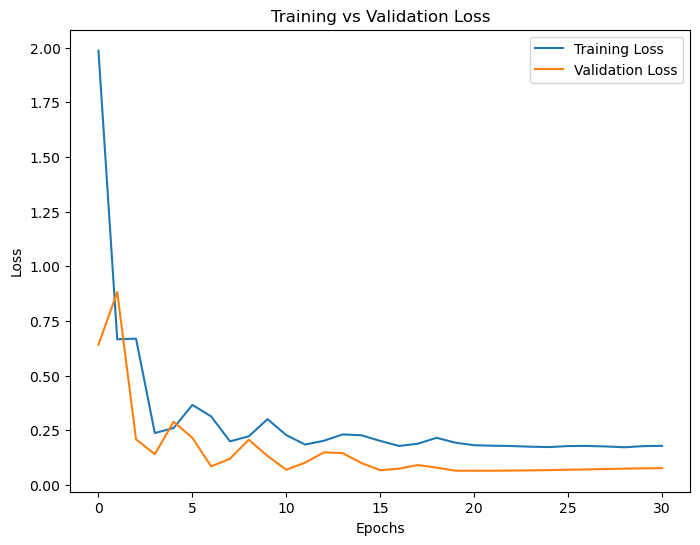

Loaded best model from epoch 21 for final evaluation.
Mean Squared Error: 0.2548
Mean Absolute Error: 0.1939


KeyboardInterrupt: 

In [26]:
rmse, mae, all_embeddings = train_gat(model, train_loader, val_loader, test_loader, num_epochs=150, lr=0.0001, device=device)

In [ ]:
node_embeddings, predicted_ratings = model.predict(test_data_obj.x, test_data_obj.edge_index, test_data_obj.edge_attr)

In [ ]:
user_ids = test_data_obj.edge_index[0]  
item_ids = test_data_obj.edge_index[1]  
true_ratings = test_data_obj.edge_attr[:, 0].cpu().numpy()
predictions = [(uid.item(), iid.item(), true_ratings[idx], predicted_ratings[idx].item()) 
               for idx, (uid, iid) in enumerate(zip(user_ids, item_ids))]

In [ ]:
with open('../Pickle/gat_embeddings.pkl', 'wb') as f:
    pickle.dump(all_embeddings, f)

In [ ]:
def evaluate_model(predictions, min_rating, k, threshold, item_popularity, num_users):
    # Denormalize predictions
    denormalized_predictions = [
        (uid, iid, true_r * (5 - min_rating) + min_rating, est * (5 - min_rating) + min_rating)
        for (uid, iid, true_r, est) in predictions
    ]

    user_est_true = defaultdict(list)
    for uid, iid, true_r, est in denormalized_predictions:
        user_est_true[uid].append((iid, est, true_r))

    precisions = []
    recalls = []
    ndcgs = []
    map_scores = []
    mrr_scores = []  # MRR scores list
    novelty_scores = []
    hit_rate_scores = []
    recommended_relevant_items = set()      # For relevant item coverage

    for user_id, user_ratings in user_est_true.items():
        # Sort predictions by estimated value
        user_ratings_sorted = sorted(user_ratings, key=lambda x: x[1], reverse=True)
        top_k = user_ratings_sorted[:k]

        top_k_items = [iid for iid, _, _ in top_k]

        # Precision and Recall
        n_rel = sum((true_r >= threshold) for (_, _, true_r) in user_ratings)
        n_rec_k = sum((true_r >= threshold) for (_, _, true_r) in top_k)
        n_rel_and_rec_k = sum((true_r >= threshold) for (_, _, true_r) in top_k)

        precision = n_rel_and_rec_k / k if k != 0 else 0
        recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        precisions.append(precision)
        recalls.append(recall)

        # NDCG@k
        dcg = sum(
            (true_r >= threshold) / np.log2(idx + 2)
            for idx, (_, _, true_r) in enumerate(top_k)
        )
        idcg = sum(
            1.0 / np.log2(idx + 2) for idx in range(min(n_rel, k))
        )
        ndcg = dcg / idcg if idcg != 0 else 0
        ndcgs.append(ndcg)

        # MAP@k
        hits = 0
        sum_precisions = 0
        for idx, (_, _, true_r) in enumerate(top_k):
            if true_r >= threshold:
                hits += 1
                sum_precisions += hits / (idx + 1)
        ap = sum_precisions / min(n_rel, k) if n_rel != 0 else 0
        map_scores.append(ap)

        # MRR@k
        # Calculate MRR by using the reciprocal rank of the first relevant item
        mrr = 0
        for idx, (_, _, true_r) in enumerate(top_k):
            if true_r >= threshold:
                mrr = 1 / (idx + 1)
                break
        mrr_scores.append(mrr)

        # Novelty (1 - average popularity of the recommended items)
        novelty = np.mean([1 - (item_popularity.get(iid, 1) / num_users) for iid in top_k_items])
        novelty_scores.append(novelty)

        # Hit Rate (proportion of users who have at least one relevant item in top_k)
        hit_rate = 1 if n_rel_and_rec_k > 0 else 0
        hit_rate_scores.append(hit_rate)

        # For Relevant Item Coverage@k
        recommended_relevant_items.update([iid for iid, est, true_r in top_k if true_r >= threshold])

    # User Coverage@k (the proportion of users with at least one relevant recommendation)
    user_coverage = sum(1 for user_ratings in user_est_true.values() if any(true_r >= threshold for _, _, true_r in user_ratings)) / len(user_est_true)

    return (
        np.mean(precisions),
        np.mean(recalls),
        np.mean(ndcgs),
        np.mean(map_scores),
        np.mean(mrr_scores),  
        np.mean(novelty_scores),
        np.mean(hit_rate_scores),
        user_coverage
    )

k = 5
threshold = 4  # Relevance threshold
item_popularity = test_data['book_id'].value_counts().to_dict()
num_users = test_data['user_id'].nunique()

# Compute metrics
precision, recall, ndcg, map_score, mrr, novelty, hit_rate, user_coverage = evaluate_model(
    predictions, min_rating=min_rating, k=k, threshold=threshold, item_popularity=item_popularity, num_users=num_users
)
print(f'Precision@{k}: {precision:.4f}')
print(f'Recall@{k}: {recall:.4f}')
print(f'nDCG@{k}: {ndcg:.4f}')
print(f'MAP@{k}: {map_score:.4f}')
print(f'MRR@{k}: {mrr:.4f}')
print(f'Novelty: {novelty:.4f}')
print(f'Hit Rate: {hit_rate:.4f}')
print(f'User Coverage: {user_coverage:.4f}')


In [ ]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

user_predictions = {}

# Loop through all predictions (user-item pairs and their predicted ratings)
for uid, iid, true_rating, predicted_rating in predictions:
    if uid not in user_predictions:
        user_predictions[uid] = []
    user_predictions[uid].append((iid, predicted_rating))

top_k = 5  # Choose the value of k, e.g., top-5 recommendations
top_k_predictions = {}

for uid, items in user_predictions.items():
    # Sort items by predicted ratings in descending order and get top-k
    sorted_items = sorted(items, key=lambda x: x[1], reverse=True)[:top_k]
    top_k_predictions[uid] = sorted_items

# Genres for top-k recommended books
predicted_book_genres = []

# Loop through top-k recommendations
for uid, top_items in top_k_predictions.items():
    for iid, predicted_rating in top_items:
        book = books[books['book_id'] == iid]  # Match book ID to the books dataset
        if not book.empty:
            genres = book.iloc[0]['filtered_genres'].split(',')  # assuming comma-separated
            predicted_book_genres.extend([genre.strip() for genre in genres])

# Count genres in top-k recommendations
predicted_genre_counts = Counter(predicted_book_genres)

# Get genre counts from the training data
genre_list = []
for genres in books['filtered_genres']:
    genre_list.extend([genre.strip() for genre in genres.split(',')])

train_genre_counts_series = pd.Series(genre_list).value_counts()
train_genre_counts_df = train_genre_counts_series.reset_index()
train_genre_counts_df.columns = ['Genre', 'Count']

# Align genres for both plots by using the training genre order
genre_order = train_genre_counts_df['Genre'].tolist()

# Reindex predicted genre counts to match training genre order
predicted_genre_counts_ordered = [predicted_genre_counts.get(genre, 0) for genre in genre_order]

# Plot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot for training data
ax[0].bar(genre_order, train_genre_counts_df['Count'], color='lightblue')
ax[0].set_xlabel('Genre')
ax[0].set_ylabel('Count')
ax[0].set_title('Genre Distribution in Gat Training Data')
ax[0].tick_params(axis='x', rotation=45)

# Plot for predicted (top-k) data
ax[1].bar(genre_order, predicted_genre_counts_ordered, color='lightgreen')
ax[1].set_xlabel('Genre')
ax[1].set_ylabel('Count')
ax[1].set_title(f'Genre Distribution of Top-{top_k} Gat Recommended Books')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
# Overlap calculation
overlap = sum(
    min(train_genre_counts_series.get(genre, 0), predicted_genre_counts.get(genre, 0)) 
    for genre in train_genre_counts_series.index
)
total_train_genres = train_genre_counts_series.sum()
total_predicted_genres = sum(predicted_genre_counts.values())

# Count total unique genres
unique_train_genres = train_genre_counts_series.index.nunique()
unique_predicted_genres = len(predicted_genre_counts)

print(f"Overlap of genres: {overlap}")
print(f"Total genres in training data (counts): {total_train_genres}")
print(f"Total genres in top-{top_k} recommendations (counts): {total_predicted_genres}")
print(f"Total unique genres in training data: {unique_train_genres}")
print(f"Total unique genres in top-{top_k} recommendations: {unique_predicted_genres}")




In [ ]:
predicted_ratings = denormalize_rating(predicted_ratings, min_rating)

In [ ]:
predicted_ratings

In [ ]:
import matplotlib.pyplot as plt

def plot_prediction_histogram(predictions):
    plt.figure(figsize=(8, 6))
    plt.hist(predicted_ratings, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Predicted Ratings Gatv2Conv')
    plt.xlabel('Predicted Ratings')
    plt.ylabel('Frequency')
    plt.show()

plot_prediction_histogram(predicted_ratings)

In [ ]:
predicted_ratings.min().item()

In [ ]:
predicted_ratings.max().item()

In [ ]:
predicted_ratings.mean()

In [ ]:
data['rating'].mean()